# 옷의 feature 추출
---

방식
    
    CNN 모델을 통해 옷 이미지로부터 feature 추출  
  
사용할 모델

1. 우리가 훈련한 모델

2. pretrained 모델  
    사실 그냥 pretrained 모델들의 weight를 그대로 써도 무방하다  
    이유 : 동일 모델에 데이터를 넣으면 동일한 기준으로 추출되므로 유사성이 보존될 것이다라는 추측

In [1]:
import os

os.chdir('..')

In [2]:
#tensorflow.keras.resnet50 과 keras.resnet50은 shape incompatible함 ㅜㅜ
#keras_pretrained에 저장된 weight를 쓸거면 keras를
#그냥 imagenet으로 쓸거면 tf.keras를
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#vgg16/19는 feature extraction 잘 안 되는것 같음
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import resnet50, vgg16, vgg19, inception_resnet_v2,inception_v3, densenet
from tensorflow.keras.applications import mobilenet,mobilenet_v2, nasnet, xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D , MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential

import pickle

In [3]:
from tqdm.notebook import tqdm

## 데이터 준비

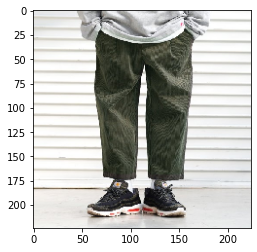

In [4]:
#모델의 사이즈인 224,224에 맞게 변경
img = image.load_img("data/musinsa/48515.jpg", target_size=(224, 224))

#이미지 확인
plt.imshow(img)

In [5]:
#PIL 이미지를 numpy array로 변경
x = image.img_to_array(img)

#array shape 확인
x.shape

(224, 224, 3)

In [6]:
# Add a forth dimension since Keras expects a list of images
x = np.expand_dims(x, axis=0)

x.shape

(1, 224, 224, 3)

In [7]:
# Scale the input image to the range used in the trained network
x = resnet50.preprocess_input(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


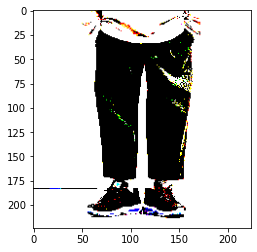

In [8]:
#전처리된 이후의 이미지 확인
plt.imshow(x.squeeze(0))

## 모델 생성 - 기존 pretrained 모델 불러오기 및 형태 확인

In [9]:
#테스트용으로 사용할 모델 - Keras Pretrained ResNet 50
RESNET50_WEIGHTS = 'models/keras_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
RESNET50_NOTOP_WEIGHTS = 'models/keras_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
#top과 notop의 차이점
model = resnet50.ResNet50(weights=RESNET50_WEIGHTS)
model_notop = resnet50.ResNet50(weights=RESNET50_NOTOP_WEIGHTS,include_top=False)

In [ ]:
#top/notop 차이 확인
#notop은 input/output layer가 없음
#notop은 따라서 input shape를 넣어줘야 함
print("----with top-----")
print("first 5 layer")
for i in range(0,5) :
    print(model.layers[i] , model.layers[i].output_shape)

print("\nlast 5 layer")
for i in range(-5,0) :
    print(model.layers[i] , model.layers[i].output_shape)
    
    
print("\n----without top-----")
print("first 5 layer")
for i in range(0,5) :
    print(model_notop.layers[i] , model_notop.layers[i].output_shape)

print("\nlast 5 layer")
for i in range(-5,0) :
    print(model_notop.layers[i] , model_notop.layers[i].output_shape)

## 모델 생성 - pretrained 모델 형태 변경

Zalando Example (VGG16) https://towardsdatascience.com/zalando-dress-recomendation-and-tagging-f38e1cbfc4a9  
->with top, output : 4096

In [4]:
#사용할 pretrained model 선택
def select_pre_model(name,weight,include_top=True) :
    name_dict = {'resnet50':resnet50.ResNet50,
                'vgg16':vgg16.VGG16,
                 'vgg19':vgg19.VGG19,
                 'inception_v2': inception_resnet_v2.InceptionResNetV2,
                 'inception_v3' : inception_v3.InceptionV3,
                 'densenet121':densenet.DenseNet121,
                 'densenet169':densenet.DenseNet169,
                 'densenet201':densenet.DenseNet201,
                 'mobilenet':mobilenet.MobileNet,
                 'mobilenet_v2': mobilenet_v2.MobileNetV2,
                 'nasnet' : nasnet.NASNetMobile,
                 'xception':xception.Xception
                }
    if top :
        return name_dict[name](weights=weight)
    else :
        return name_dict[name](weights=weight,include_top=False,input_shape=(224,224,3))

In [5]:
top= True # True/False : input/output layer 포함/미포함
name = 'vgg19'
pretrained_model = select_pre_model(name,'imagenet',include_top=top)

In [6]:
#pretrained 모델의 input/output layer 확인
print('Input_layer_type= {}'.format(pretrained_model.layers[0]))
print('Input_layer_shape= {}'.format(pretrained_model.layers[0].input_shape))
print('Output_layer_type= {}'.format(pretrained_model.layers[-1]))
print('Output_layer_shape= {}'.format(pretrained_model.layers[-1].output_shape))
print("모델 layer 깊이 :",len(pretrained_model.layers))

Input_layer_type= <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000246A3AD1948>
Input_layer_shape= [(None, 224, 224, 3)]
Output_layer_type= <tensorflow.python.keras.layers.core.Dense object at 0x00000246D3D8E708>
Output_layer_shape= (None, 1000)
모델 layer 깊이 : 26


In [7]:
#input layer 근처 5 layer 형태 파악
for i in range(0,5) :
    print(pretrained_model.layers[i] , pretrained_model.layers[i].output_shape)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000246A3AD1948> [(None, 224, 224, 3)]
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246A3AE4848> (None, 224, 224, 64)
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246A3B33FC8> (None, 224, 224, 64)
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000246CE89D948> (None, 112, 112, 64)
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000246CE8A7248> (None, 112, 112, 128)


In [8]:
#output layer 근처 5 layer 형태 파악
for i in range(-5,0) :
    print(pretrained_model.layers[i] , pretrained_model.layers[i].output_shape)

<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000246D3D56D88> (None, 7, 7, 512)
<tensorflow.python.keras.layers.core.Flatten object at 0x00000246D3D67748> (None, 25088)
<tensorflow.python.keras.layers.core.Dense object at 0x00000246D3D7DD88> (None, 4096)
<tensorflow.python.keras.layers.core.Dense object at 0x00000246D3D82CC8> (None, 4096)
<tensorflow.python.keras.layers.core.Dense object at 0x00000246D3D8E708> (None, 1000)


In [9]:
#Top 여부에 따라 모델의 마지막 레이어 날리기
#top=True면 날리기, Top=False면 날리지 말기
#Model 오브젝트에 바로 predict를 하면 에러가 뜨므로, 싫더라도 반드시 Sequential을 새로 만들어서 add해줘야 함
last_layer = -2 

if top :
    new_model = Model(pretrained_model.inputs, pretrained_model.layers[last_layer].output)  # assuming you want the 3rd layer from the last

else :
    model = Model(pretrained_model.inputs,pretrained_model.outputs)
    # 새 모델에 Avg Pooling 추가
    new_model = Sequential()
    new_model.add(model)
    new_model.add(GlobalAveragePooling2D())

In [10]:
#새 모델의 input/output layer 확인
new_model.layers[0].input_shape, new_model.layers[-1].output_shape

([(None, 224, 224, 3)], (None, 4096))

In [18]:
#과거 모델 지우기
clear_session()
del pretrained_model
del model

NameError: name 'model' is not defined

## feature 추출
---
feature vector의 형태

feature vector의 차원과 성능의 관계

    너무 커도 안좋고 너무 작아도 안좋다
    크면 : size가 커져 handling이 어려움. Clustering 등에서 차원의 저주 발생.  
    feature 하나하나의 중요도가 급격히 떨어지고 feature간 종속관계로 인한 정보의 밀도가 낮아짐
    작으면 : feature가 축소되는 과정에서 원래의 이미지가 갖고 있는 정보들이 손실됨
    
최종 size 결정

    512/1024/2048/4096 순으로 변경해가면서 test
    (Zalando 튜토리얼에서는 4096으로 했음)

In [11]:
import pymysql
import json

def connect_db(dbinfo_path) :
    with open(dbinfo_path) as jsonfile :
        dbinfo = json.load(jsonfile)

    connection = pymysql.connect(host=dbinfo['host'],
                         port=dbinfo['port'],
                         user=dbinfo['user'], 
                         passwd=dbinfo['passwd'],
                         db=dbinfo['db'],
                         charset=dbinfo['charset'])
    
    return connection

In [12]:
db = connect_db('dbinfo-temp.json')
cur = db.cursor()

feature 추출 1 - 임의데이터 3000개로부터 feature 추출

In [67]:
cur = db.cursor()
sql = """SELECT clothes_id,minor FROM CLOTHES_AND_CLOTHES_CLASS 
INNER JOIN CLOTHES ON CLOTHES.id = CLOTHES_AND_CLOTHES_CLASS.clothes_id 
INNER JOIN CLOTHES_CLASS ON CLOTHES_AND_CLOTHES_CLASS.clothes_class_id = CLOTHES_CLASS.id
WHERE clothes_class_id IN 
(SELECT id FROM CLOTHES_CLASS 
WHERE (major="남" OR major="여") 
AND (middle != "" AND middle != "가방" AND middle!="스포츠/용품")) 
ORDER  BY clothes_id ASC 
LIMIT 3000;"""

cur.execute(sql)

3000

In [ ]:
#이미지 번호와 result를 각각 train/test dict로 저장
#평균 20it/sec
train_result_dict = {}
for id, _ in  tqdm(cur) :
    try :
        img = image.load_img("data/musinsa/{}.jpg".format(id), target_size=(224, 224))
    except :
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    result = new_model.predict(x)
    
    train_result_dict[id] = result

카테고리별 feature 확보

In [15]:
#minor 카테고리별 개수 파악
#DB내 카테고리별 개수 파악후, 최소값이라기보단 최대값 n개로 한정해서 최대 n*80개 feature 셋 확보
#내가보기에 어차피 사용자의 시선이 좁은 것을 감안하면 카테고리당 최대 1000개만 해도 충분할 것 같음

sql = """SELECT clothes_class_id, major,minor 
FROM CLOTHES_AND_CLOTHES_CLASS 
INNER JOIN CLOTHES_CLASS ON CLOTHES_AND_CLOTHES_CLASS.clothes_class_id = CLOTHES_CLASS.id 
GROUP BY clothes_class_id 
HAVING (major="남" OR major="여") AND major!="아동" 
AND minor NOT LIKE "(%" AND minor!="웨이스트 백" AND minor!="기능성 상의" AND minor!="기능성 하의";"""

cur.execute(sql)

78

In [16]:
minor_id_map = {}
for id,major,minor in cur :
    minor_id_map[id] = (major,minor)

In [17]:
minor_id_map

{52: ('남', '반팔 티셔츠'),
 53: ('여', '반팔 티셔츠'),
 54: ('남', '긴팔 티셔츠'),
 55: ('여', '긴팔 티셔츠'),
 56: ('여', '민소매 티셔츠'),
 57: ('남', '민소매 티셔츠'),
 58: ('남', '셔츠/블라우스'),
 59: ('여', '셔츠/블라우스'),
 60: ('남', '피케/카라 티셔츠'),
 61: ('여', '피케/카라 티셔츠'),
 62: ('남', '맨투맨/스웨트셔츠'),
 63: ('여', '맨투맨/스웨트셔츠'),
 64: ('남', '후드 스웨트셔츠/후드 집업'),
 65: ('여', '후드 스웨트셔츠/후드 집업'),
 66: ('여', '니트/스웨터/카디건'),
 67: ('남', '니트/스웨터/카디건'),
 68: ('여', '베스트'),
 69: ('남', '베스트'),
 70: ('남', '기타 상의'),
 71: ('여', '기타 상의'),
 72: ('여', '블루종/MA-1'),
 73: ('남', '블루종/MA-1'),
 74: ('남', '레더/라이더스 재킷'),
 75: ('여', '레더/라이더스 재킷'),
 76: ('남', '트러커 재킷'),
 77: ('여', '트러커 재킷'),
 78: ('여', '수트/블레이저 재킷'),
 79: ('남', '수트/블레이저 재킷'),
 80: ('남', '아노락 재킷'),
 81: ('여', '아노락 재킷'),
 82: ('남', '나일론/코치  재킷'),
 83: ('여', '나일론/코치  재킷'),
 84: ('남', '기타 아우터'),
 85: ('남', '트레이닝 재킷'),
 86: ('여', '트레이닝 재킷'),
 87: ('남', '스타디움 재킷'),
 88: ('여', '스타디움 재킷'),
 89: ('남', '환절기 코트'),
 90: ('여', '환절기 코트'),
 91: ('남', '겨울 싱글 코트'),
 92: ('여', '겨울 싱글 코트'),
 93: ('남', '겨울 기타 코트'),
 94: (

In [18]:
#minor 카테고리별로 쿼리 요청해서 카테고리 내 존재하는 옷들의 id와 path 확보
#먼저 id부터 받고-> 경로 저장
#1000개로 한정짓기 -> 그냥 전체를 다 하는게 맞음
def get_clothes_in_minor(minor_id) :
    sql = """SELECT clothes_id FROM CLOTHES_AND_CLOTHES_CLASS
            WHERE clothes_class_id={};""".format(minor_id)

    cur.execute(sql)
    
    id_path_map = {}
    for id in cur :
        id_path_map[id[0]] = "data/musinsa/{}.jpg".format(id[0])
    
    return id_path_map

In [19]:
for minor_id in tqdm(minor_id_map.keys()) :
    id_path_map = get_clothes_in_minor(minor_id)
    image_result_dict = {}
    for id,path in tqdm(id_path_map.items()) :
        try :
            img = image.load_img(path,target_size=(224,224))
        except :
            continue
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = vgg19.preprocess_input(x)
        result = new_model.predict(x)
        
        image_result_dict[id] = result
    
    #결과 dict을 pickle로 저장
    if os.path.exists('prep_data/minor_feature/{}'.format(name)) == False :
        os.mkdir('prep_data/minor_feature/{}'.format(name))
    with open('prep_data/minor_feature/{}/{}.pickle'.format(name,minor_id), 'wb') as handle:
        pickle.dump(image_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 추출된 feature 저장

pickle로 저장

In [20]:
#잘 저장되었나 확인
with open('prep_data/minor_feature/vgg19/63.pickle', 'rb') as f:
    data = pickle.load(f)    

In [21]:
data

{868: array([[0.       , 0.       , 0.       , ..., 0.       , 1.5752172,
         1.3549917]], dtype=float32),
 869: array([[0.       , 0.       , 0.       , ..., 0.       , 2.5408788,
         1.5625796]], dtype=float32),
 870: array([[0.        , 0.        , 0.        , ..., 0.        , 0.9352283 ,
         0.45073658]], dtype=float32),
 894: array([[0.       , 0.       , 0.       , ..., 0.       , 3.6145568,
         0.9138897]], dtype=float32),
 904: array([[0.       , 0.       , 0.       , ..., 0.       , 5.7030134,
         0.       ]], dtype=float32),
 907: array([[0.       , 0.       , 0.       , ..., 0.       , 5.7332945,
         1.0604622]], dtype=float32),
 923: array([[0.       , 0.       , 0.       , ..., 0.5060543, 4.1903543,
         0.       ]], dtype=float32),
 927: array([[0.       , 0.       , 0.       , ..., 0.       , 3.9323363,
         0.       ]], dtype=float32),
 928: array([[0.       , 0.       , 0.       , ..., 2.1122203, 4.547756 ,
         0.       ]], dt

tfRecord로 저장

---

tfRecord에 대한 구체적인 설명 https://ingeec.tistory.com/89

In [ ]:
# feature vector를 tf model에 넣어서 유사도 계산할 것도 아닌데 굳이 필요할까 싶음